In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [4]:
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # 사진의 좌우를 바꿔버린다.
        tf.keras.layers.RandomRotation(0.1), # 사진을 10% 변경
        tf.keras.layers.RandomZoom(0.1), # zoom in, out (10%를 가까이서 보거나 멀리서 보거나)
    ]
)

In [ ]:
data_augmentation

<Sequential name=sequential, built=False>

In [ ]:
print(x_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000,)


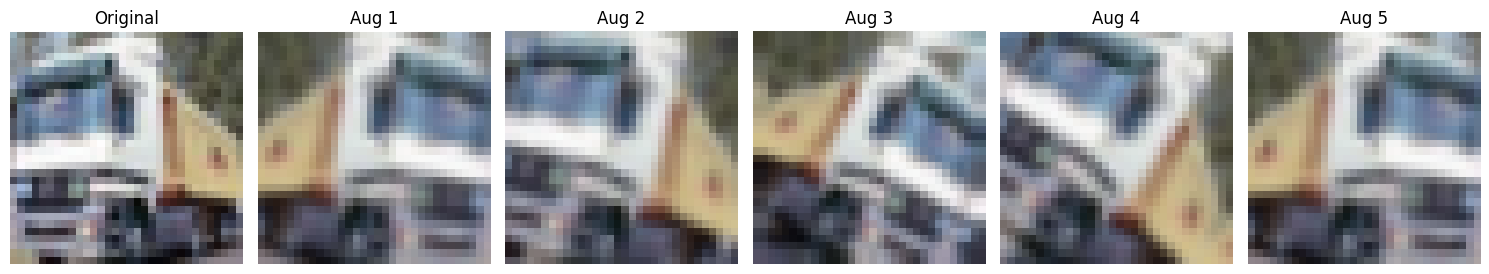

In [6]:
sample = x_train[1]

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
axes[0].imshow(sample)
axes[0].set_title("Original")
axes[0].axis("off")

for i in range(1, 6):
  aug_img = data_augmentation(tf.expand_dims(sample, 0))[0].numpy() # (32, 32, 3) -> (1, 32, 32, 3)
  axes[i].imshow(aug_img)
  axes[i].set_title(f"Aug {i}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
i = Input(shape = x_train[0].shape)
x = data_augmentation(i)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x) # training의 안정화와 빠른 수렴을 도움
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x) # 특정 맵의 크기를 2분의 1로 줄임

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
 122/1563 ━━━━━━━━━━━━━━━━━━━━ 7:27 311ms/step - accuracy: 0.2633 - loss: 5.2912

In [ ]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.7708 - loss: 1.0266


[1.061340570449829, 0.7652000188827515]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
train_dataset = train_dataset.shuffle(
    buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
r = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 548s 348ms/step - accuracy: 0.9701 - loss: 0.0959 - val_accuracy: 0.7323 - val_loss: 1.4293
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 539s 345ms/step - accuracy: 0.9707 - loss: 0.0911 - val_accuracy: 0.7606 - val_loss: 1.0494
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 545s 349ms/step - accuracy: 0.9693 - loss: 0.0969 - val_accuracy: 0.7183 - val_loss: 1.7672
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 560s 358ms/step - accuracy: 0.9711 - loss: 0.0890 - val_accuracy: 0.7796 - val_loss: 1.0496
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 546s 349ms/step - accuracy: 0.9745 - loss: 0.0771 - val_accuracy: 0.7463 - val_loss: 1.1568
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 550s 352ms/step - accuracy: 0.9729 - loss: 0.0862 - val_accuracy: 0.7661 - val_loss: 1.1612
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 552s 353ms/step - accuracy: 0.9761 - loss: 0.0763 - val_accuracy: 0.7612 - val_loss: 1.1309
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 552s 347ms/step - ac

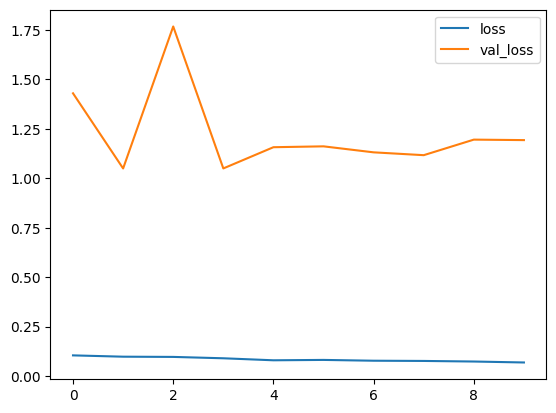

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

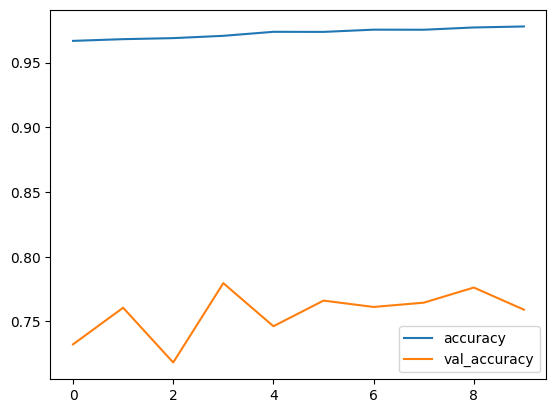

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
# 열 가지 데이터의 오브멘트,,? 프리딕트하는지 테스트

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step


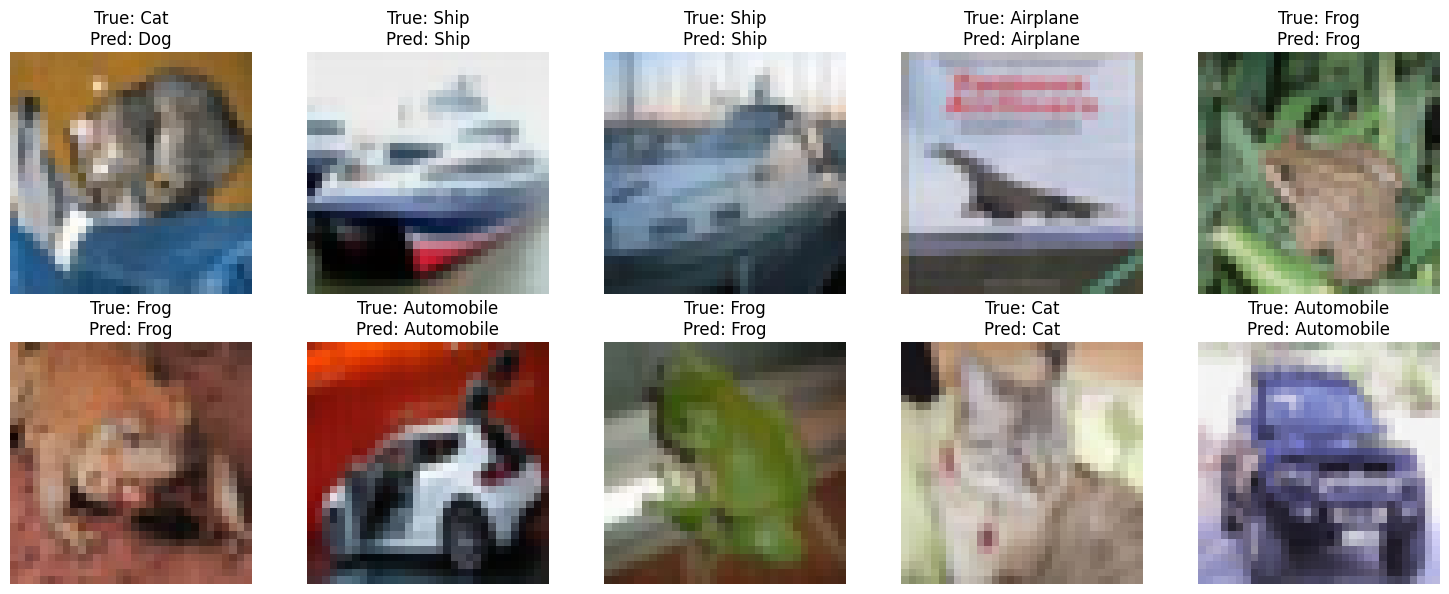

In [ ]:
import matplotlib.pyplot as plt

preds = model.predict(x_test)
pred_labels = preds.argmax(axis=1)

class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    true = class_names[y_test[i]]
    pred = class_names[pred_labels[i]]
    plt.title(f"True: {true}\nPred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()